# Traditional Machine Learning

We first begin by importing the libraries that we will need for performing the preprocessing and algorithm training in this tutorial. Let's summarize what we will do today:

#### Preprocessing
- Data augmentation
  - [Synthetic Minority Oversampling and Edited Nearest Neighbours (SMOTEENN)](https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50)
  - [Oversample using Adaptive Synthetic (ADASYN)](https://towardsdatascience.com/the-mystery-of-adasyn-is-revealed-73bcba57c3fe)

#### Algorithms
- [Decision Tree (DT)](https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6)
- [Support Vector Machine (SVM)](https://towardsdatascience.com/support-vector-machine-explained-8bfef2f17e71)


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

The first step is to use the *pd.read_csv()* method to read the dataset that is in CSV format and store it inside a *Pandas* Dataframe, which is typically used for processing tabular data in machine learning. In he next step we print the dataframe (that we named "df") to inspect its characteristics. The output provides us with the dimensions of 288602 rows and 79 columns. This means that there are 288602 data samples in our dataset and 79 columns representing the dataset features, that we will use to train the machine learning models later. Upon closer inspection, it also appears that the very first column is not a feature but simply an index of each data sample (i.e., row) and the very last column  (" Label") contains the teacher label that will be used as the ground truth of the dataset. Other features include the "Destination Port", the "Total Length of Fwd Packets" and the "Idle Mean". 

We subsequently use the *value_counts()* method to check what labels are available across all rows. The output shows that in the dataset there are 288566 "BENIGN" labels and 36 "Infiltration" labels that represent malicious traffic.

In [45]:
df = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')

In [46]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288597,80,590930,2,0,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
288598,80,1187988,2,0,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
288599,80,10,1,9,6,54,6,6,6.0,0.0,...,20,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
288600,138,19,10,0,2370,0,237,237,237.0,0.0,...,20,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN


In [47]:
# Inspect all labels in the dataset
counts = df[' Label'].value_counts()
print(counts)

 Label
BENIGN          288566
Infiltration        36
Name: count, dtype: int64


In the next step, we have to do some elementary preprocessing that is required to ensure that all the cells in the dataset are populated and that there are no invalid entries. We specifically want to check for any empty ("NaN") cells across the rows, or any numbers that are infinitely large. In some cases datasets can contain too many entries with empty numbers, and we therefore count and print the number of rows of such instances. In our example there are only 18 rows where there is at least one NaN entry in the columns, and 207 instances of infinite values. The reason why we check for these is because we want to remove them from the dataset so that they do not result in code execution issues, as they have possibly been introduced by dataset errors. It is also important to count them, because if they are too many then we may end up removing a large part of the dataset, which is undesirable.

Then, we want to convert the string labels to numerical labels, so that they can be processed by the algorithms during training. We do this by applying the *replace()* method on the the " Label" column of the dataframe. All "BENIGN" strings are replaced by the number 0 and all "Infiltration" (i.e., malicious activity) labels are replaced by the number 1.

In the next cell we split the dataset (i.e., the entire dataframe) into the features that will be used to extract useful information during training (*X_original*) and the teacher labels (*y_original*). Then we use the *MinMaxScaler()* function of scikit-learn to scale all features cells to have values between 0.0 and 1.0. Importantly, the variable produced ("X_scaled") as output is now a *numpy* array, and not a dataframe anymore. The values are scaled because standardizing the values in datasets has been shown to be important in machine learning algorithms, and it can eliminate the possibility of the different scales of different features biasing what the classifier learns. Lastly, the minimum and maximum values across both dimensions (rows and columns) is printed to verify that the lowest value is 0.0 and the highest 1.0.

In [48]:
# Preprocessing: Remove all rows with NaN or inf values

# Count rows with at least one NaN value
nan_rows_indices = df.index[df.isna().any(axis=1)].tolist()
nan_rows_count = len(nan_rows_indices)
print("Number of rows with at least one NaN value:", nan_rows_count)

# Exclude last column because it has strings and the check for inf numbers throws an error
X = df.iloc[:, 0:-1]

# Count rows with at least one infinite value
inf_rows_indices = X.index[np.isinf(X).any(axis=1)].tolist()
inf_rows_count = len(inf_rows_indices)
print("Number of rows with at least one inf value:", inf_rows_count)

# Combine indices of rows with NaN or inf values
rows_to_drop = set(nan_rows_indices + inf_rows_indices)

# Drop rows with at least one NaN or inf value
df2 = df.drop(index=rows_to_drop)

Number of rows with at least one NaN value: 18
Number of rows with at least one inf value: 207


In [49]:
# Make the labels numerical
df2[' Label'] = df2[' Label'].replace({'BENIGN': 0, 'Infiltration': 1})
label_counts = df2[' Label'].value_counts()
print(label_counts)

 Label
0    288359
1        36
Name: count, dtype: int64


In [50]:
# Split dataset into features and labels
X_original = df2.iloc[:,0:-1]
y_original = df2.iloc[:, -1]

In [51]:
# Transform the features to only have a range [0, 1]. Note that the scaled data are now a numpy array, not a df
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_original)

# Print the min and max of values in the scaled dataframe
print(X_scaled.max(axis=None))
print(X_scaled.min(axis=None))

1.0
0.0


Below we define a custom function *data_split* that takes as input the "X_scaled" *numpy* array containing the dataset features, a dataframe "y_original" with the correct labels and the test ratio. The test ratio defines what percentage of the data the user wants to keep for testing the performance of the models, with the remaining data being used for model training.

In the beginning the dataframe "y" is converted to a *numpy* array before proceeding to implement the code for splitting the data into train and test subsets for each of the two parts: the features "X_scaled" and the labels "y_original". In the first step, the *np.where()* method is used to extract the indices for each label and later we use those to slice the dataset using the indices as predefined by the "test_ratio". We next shuffle the dataset so that sampling is radom, eliminating any sampling bias that can occur by selecting data that are close together during the data split. The resulting variables are the following:

 - X_train: the training subset contaning the features to be used for training. It consists of 70% of the dataset.
 - X_test: the test subset reserved for testing model performance containing the samples with features. In the example above 30% of the data are used for testing.
 - y_train: the training subset contaning the labels to be used for training. It consists of 70% of the dataset.
 - y_test: the test subset reserved for testing model performance and includes all training features. It is 30% of the data.

 We call the function using *X_train, X_test, y_train, y_test = data_split(X_scaled, y_original)* and the length of each array to verify that the splitting went well and that the total number of elements in each training set is identical. We do the same for the test sets.

In [53]:
# Function to split dataset into training and testing data
def data_split(X=X_scaled, y=y_original, test_ratio=0.3):

    # X is already an array from when we normalized the numbers between 0 and 1.
    # Convert y to an array too.
    y = y.to_numpy()

    # Extract indices of each of the two classes in the dataframe 
    benign_indices = np.where(y == 0)[0]
    malicious_indices = np.where(y == 1)[0]

    # Shuffle array and sample the indices according to the specified test_ratio
    np.random.shuffle(benign_indices)
    np.random.shuffle(malicious_indices)

    index_benign = int(test_ratio * len(benign_indices))
    index_malicious = int(test_ratio * len(malicious_indices))

    benign_indices_test = benign_indices[:index_benign]
    malicious_indices_test = malicious_indices[:index_malicious]

    benign_indices_train = benign_indices[index_benign:]
    malicious_indices_train = malicious_indices[index_malicious:]

    X_train = X[np.concatenate((benign_indices_train, malicious_indices_train)), :]
    X_test = X[np.concatenate((benign_indices_test, malicious_indices_test)), :]
    y_train = y[np.concatenate((benign_indices_train, malicious_indices_train))]
    y_test = y[np.concatenate((benign_indices_test, malicious_indices_test))]

    return X_train, X_test, y_train, y_test

In [56]:
X_train, X_test, y_train, y_test = data_split(X_scaled, y_original) 

print(len(X_scaled))
print(len(y_original))

print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

288395
288395
201878
201878
86517
86517


In the next section, we will focus on training the models. We instantiate a *DecisionTreeClassifier()* object that we name "dt_model" for "Decision Tree" model. Upon instantiating the classifier we use the *model.fit()* method to fit the model to the data. In other words, the algorithm is trained on the data so that it extracts relevant features that can aid it in minimizing the number of errors when predicting labels for the "X_test" data. This prediction (or inference) step is performed using the *model.predict()* method.

We specifically train a number of models with different setups and preprocessing steps in order to determine which performs best for our dataset through experimentation. We conduct the following experiments with the following configurations:

 - DT algorithm without data sugmentation
 - SVM algorithm without data augmentation
 - DT algorithm with data segmentation (SMOTEENN algorithm)
 - DT algorithm with data segmentation (ADASYN algorithm)
 - SVM algorithm with data segmentation (SMOTEENN algorithm)
 - SVM algorithm with data segmentation (ADASYN algorithm)

In the step that follows, we assess how well each of the models performs by computing relevant accuracy metrics and by plotting a confusion-matrix. A *confusion-matrix* provides visually shows the number of correct and incorrect predictions made per class (in our case there are two classes: for benign and non-benign traffic). We implement the confusion matrix using *disp = ConfusionMatrixDisplay.from_estimator()* and by passing as input the corresponding model, the test features and the test labels.

Other than computing the accuracy, we additionally compute the precision, recall and F1 scores that summarize the performance of our models, and we can use them to decide which one is best for classifying our data into benign and malicious traffic. Those predicts compute a single number each that is based on the number of true/false positive and true/false negatives.

Accuracy: 0.9998497405134251
Precision: 0.4
Recall: 0.6
F1 Score: 0.48


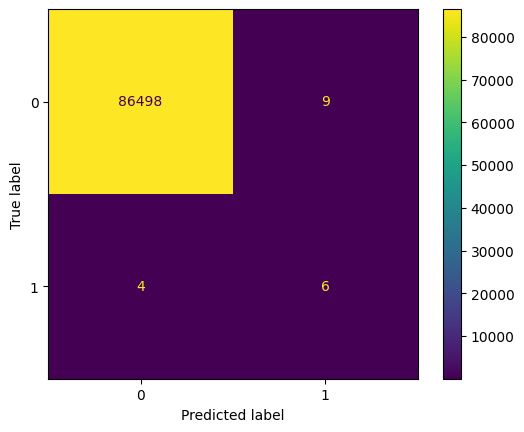

In [57]:
# Create the Decision Tree classifer 
dt_model = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_model = dt_model.fit(X_train,y_train)

# Make a prediction
y_pred_dt = dt_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(estimator=dt_model, X=X_test, y =y_test)
plt.savefig("1_dt_noaugm.png")

plt.show()

Accuracy: 0.999895974201602
Precision: 1.0
Recall: 0.1
F1 Score: 0.18181818181818182


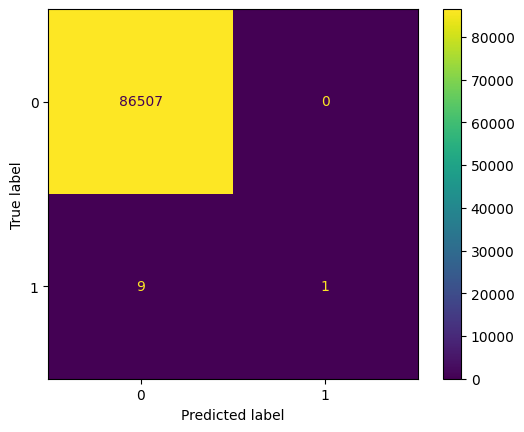

In [58]:
# Create the SVM classifer 
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train,y_train)
y_pred_svm = svm_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

disp = ConfusionMatrixDisplay.from_estimator(estimator=svm_model, X=X_test, y =y_test)
plt.savefig("2_svm_noaugm.png")

plt.show()

In the code below use create the objects "sme" and "adasyn" that comprise the *SMOTE-ENN* and *ADASYN* augmentation alogorithms respectively. Next, we create the variables "X_augmented_smoteenn" and "y_augmented_smoteenn" with the features array and the labels of the training dataset respectively. We do the same for the *ADASYN* algorithm by creating the variables "X_augmented_ada" and "y_augmented_ada".

In [59]:
# Data augmentation technique one: SMOTEENN
print('Total data before augmentation %s' % Counter(y_original))
sme = SMOTEENN()
X_augmented_smoteenn, y_augmented_smoteenn = sme.fit_resample(X_train, y_train)
print('Total Data after SMOTEENN augmentation %s' % Counter(y_augmented_smoteenn))

# Data augmentation technique one: ADASYN
adasyn = ADASYN()
X_augmented_ada, y_augmented_ada = adasyn.fit_resample(X_train, y_train)
print('Total Data after ADASYN augmentation %s' % Counter(y_augmented_smoteenn))

Total data before augmentation Counter({0: 288359, 1: 36})
Total Data after SMOTEENN augmentation Counter({1: 201850, 0: 201812})
Total Data after ADASYN augmentation Counter({1: 201850, 0: 201812})


Accuracy: 0.9999884415779557
Precision: 0.9090909090909091
Recall: 1.0
F1 Score: 0.9523809523809523


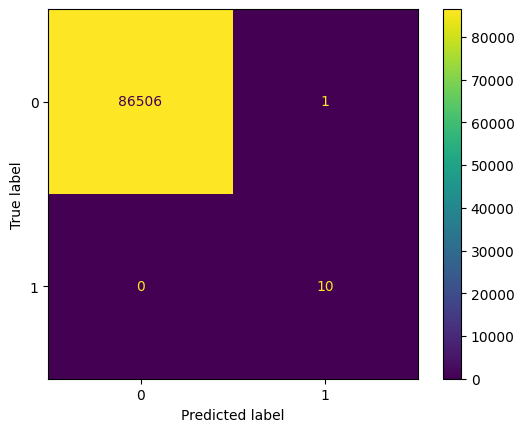

In [60]:
# Evaluate the performance of decision tree classifier on the augmented SMOTEENN dataset
dt_model_smoteenn = DecisionTreeClassifier()
dt_model_smoteenn = dt_model_smoteenn.fit(X_augmented_smoteenn,y_augmented_smoteenn)
y_pred_dt = dt_model_smoteenn.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

disp = ConfusionMatrixDisplay.from_estimator(estimator=dt_model_smoteenn, X=X_test, y =y_test)
plt.savefig("3_dt_smoteenn.png")

plt.show()

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


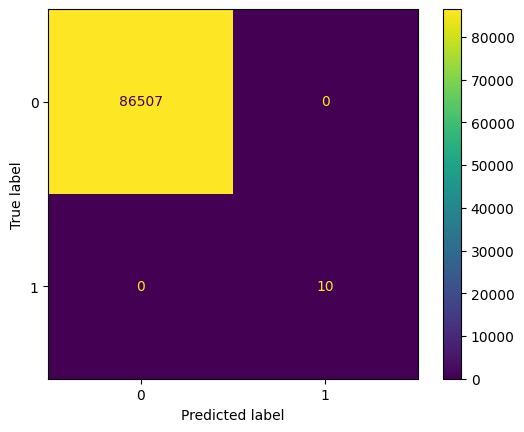

In [61]:
# Evaluate the performance of decision tree classifier on the augmented ADASYN dataset
dt_model_ada = DecisionTreeClassifier()
dt_model_ada = dt_model_ada.fit(X_augmented_ada,y_augmented_ada)
y_pred_dt = dt_model_ada.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

disp = ConfusionMatrixDisplay.from_estimator(estimator=dt_model_ada, X=X_test, y =y_test)
plt.savefig("4_dt_ada.png")

plt.show()

Accuracy: 0.998705456731047
Precision: 0.05263157894736842
Recall: 0.6
F1 Score: 0.09677419354838708


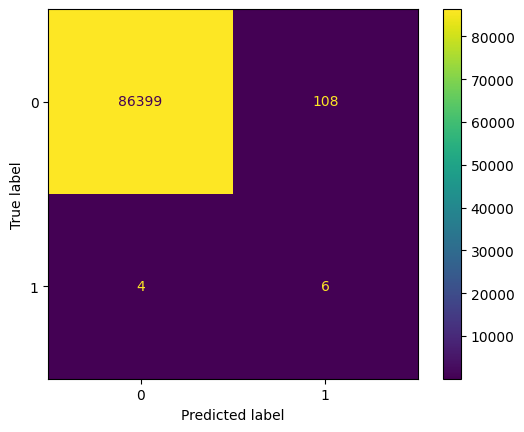

In [62]:
# Evaluate the performance of svm classifier on the augmented SMOTEENN dataset
svm_model_smoteenn = svm.SVC()
svm_model_smoteenn = svm_model_smoteenn.fit(X_augmented_smoteenn,y_augmented_smoteenn)
y_pred_svm = svm_model_smoteenn.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

disp = ConfusionMatrixDisplay.from_estimator(estimator=svm_model_smoteenn, X=X_test, y =y_test)
plt.savefig("5_svm_smoteenn.png")

plt.show()

Accuracy: 0.9985320804003838
Precision: 0.046511627906976744
Recall: 0.6
F1 Score: 0.08633093525179857


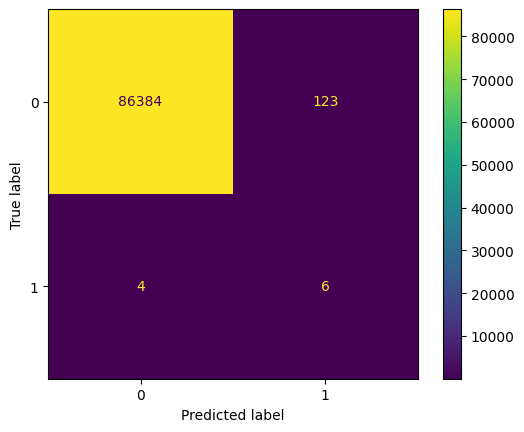

In [63]:
# Evaluate the performance of svm classifier on the augmented ADASYN dataset
svm_model_ada = svm.SVC()
svm_model_ada = svm_model_ada.fit(X_augmented_ada,y_augmented_ada)
y_pred_svm = svm_model_ada.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

disp = ConfusionMatrixDisplay.from_estimator(estimator=svm_model_ada, X=X_test, y =y_test)
plt.savefig("6_svm_ada.png")

plt.show()